# Predikcia hodnotenia filmov na IMDB

## Načítanie a analýza dát

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import tabulate

from IPython.display import HTML, display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier


sb.set(style='white')
#pd.set_option('display.max_columns', None)


movies = pd.read_csv('data/movie_metadata.csv')
movies

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0
5,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,...,738.0,English,USA,PG-13,263700000.0,2012.0,632.0,6.6,2.35,24000
6,Color,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,336530303.0,Action|Adventure|Romance,...,1902.0,English,USA,PG-13,258000000.0,2007.0,11000.0,6.2,2.35,0
7,Color,Nathan Greno,324.0,100.0,15.0,284.0,Donna Murphy,799.0,200807262.0,Adventure|Animation|Comedy|Family|Fantasy|Musi...,...,387.0,English,USA,PG,260000000.0,2010.0,553.0,7.8,1.85,29000
8,Color,Joss Whedon,635.0,141.0,0.0,19000.0,Robert Downey Jr.,26000.0,458991599.0,Action|Adventure|Sci-Fi,...,1117.0,English,USA,PG-13,250000000.0,2015.0,21000.0,7.5,2.35,118000
9,Color,David Yates,375.0,153.0,282.0,10000.0,Daniel Radcliffe,25000.0,301956980.0,Adventure|Family|Fantasy|Mystery,...,973.0,English,UK,PG,250000000.0,2009.0,11000.0,7.5,2.35,10000


### Chýbajúce hodnoty

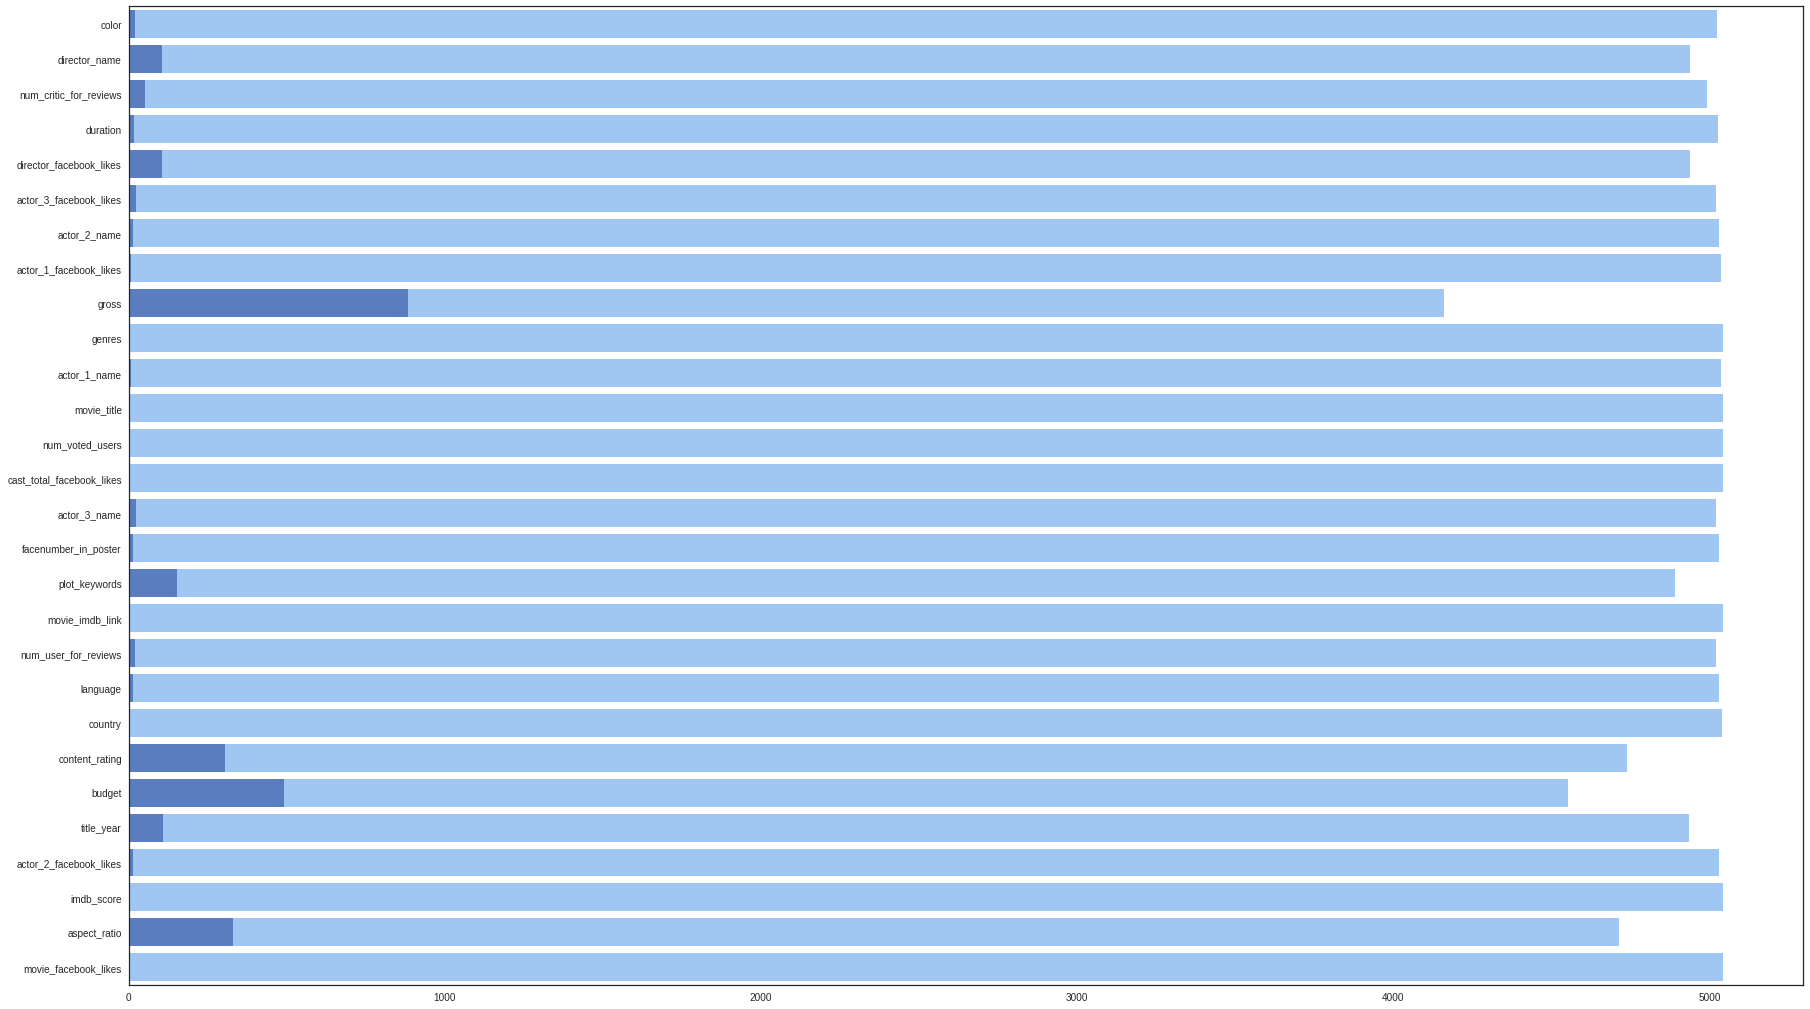

color,19,0.38%
director_name,104,2.06%
num_critic_for_reviews,50,0.99%
duration,15,0.30%
director_facebook_likes,104,2.06%
actor_3_facebook_likes,23,0.46%
actor_2_name,13,0.26%
actor_1_facebook_likes,7,0.14%
gross,884,17.53%
actor_1_name,7,0.14%
actor_3_name,23,0.46%


In [2]:
_, ax = plt.subplots(figsize=(30, 18))
sb.set_color_codes('pastel')
sb.barplot(x=movies.count(), y=movies.columns, color='b')
sb.set_color_codes('muted')
sb.barplot(x=movies.isnull().sum(), y=movies.columns, color='b')
sb.plt.show()
sb.plt.clf()

def report_missing_values(columns=None):
    total = len(movies.index)
    table = []
    columns = columns or movies.columns
    for column in columns:
        missing = sum(pd.isnull(movies[column]))
        if missing > 0:
            table.append([column, missing, '{:.2f}%'.format(missing / total * 100)])
    display(HTML(tabulate.tabulate(table, tablefmt='html')))
    
report_missing_values()

### Korelačná matica

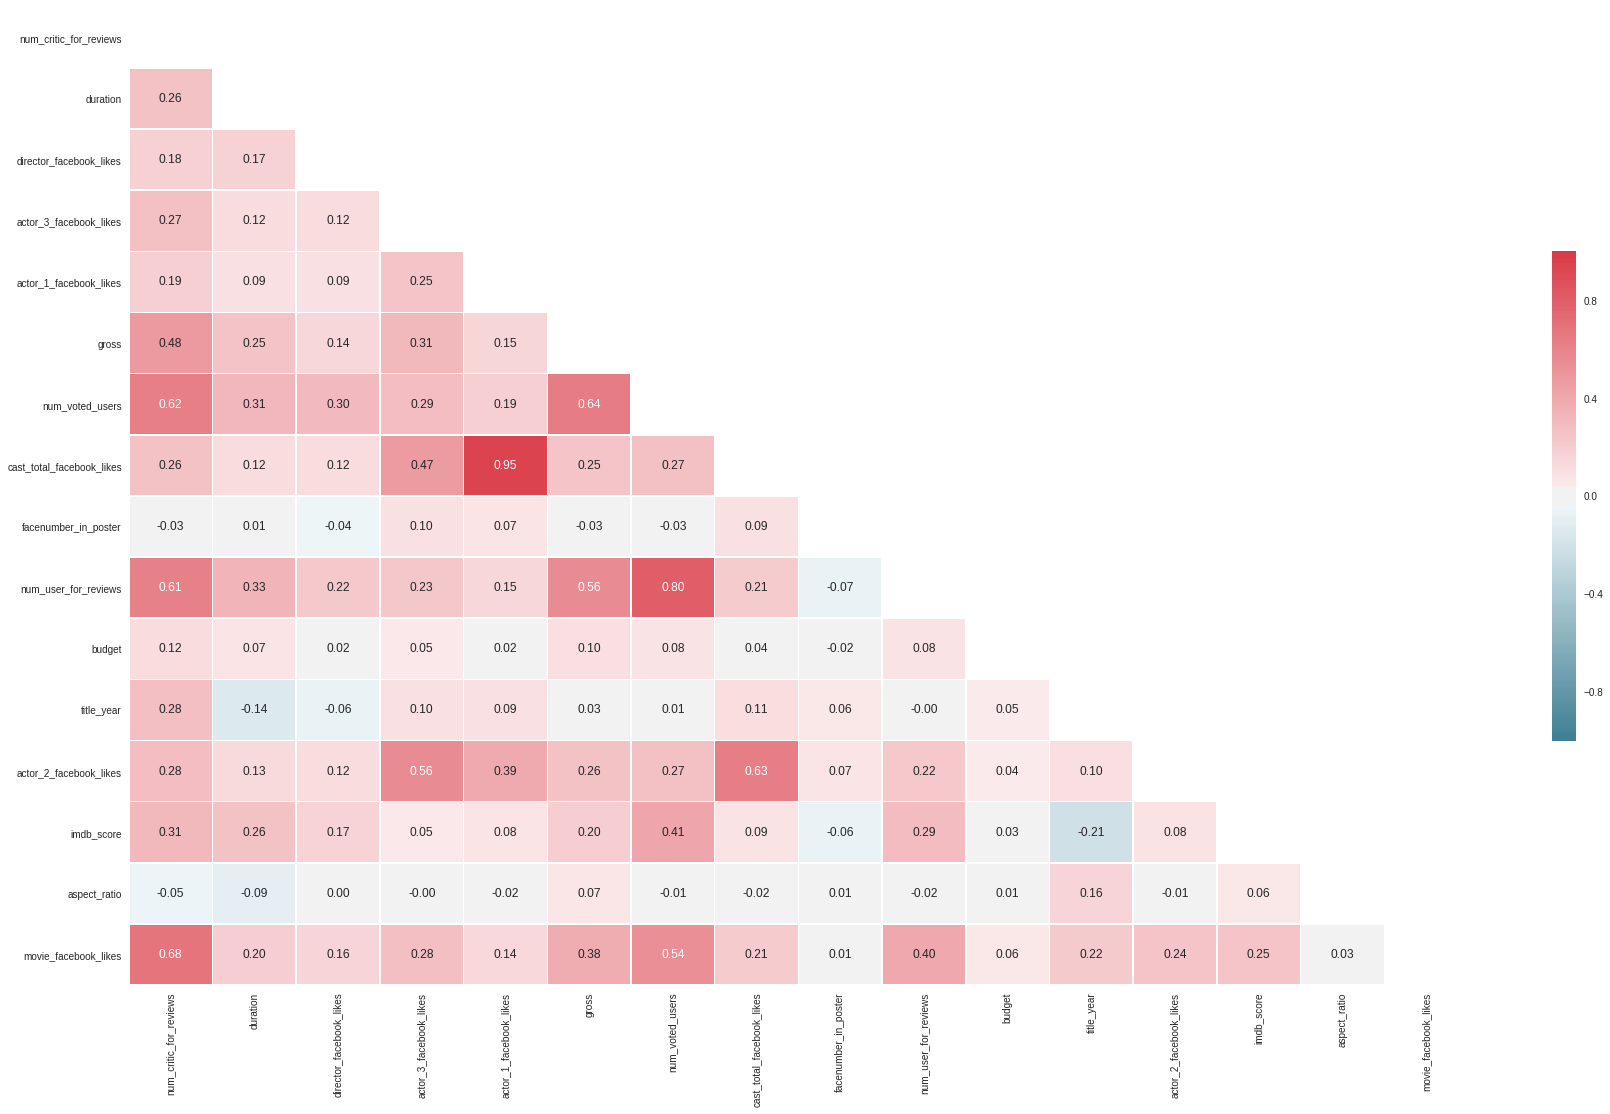

In [3]:
def show_correlation_matrix(annot=False):
    corr = movies.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sb.diverging_palette(220, 10, as_cmap=True)
    _, ax = plt.subplots(figsize=(30, 18))
    sb.heatmap(corr, mask=mask, cmap=cmap, ax=ax, linewidths=0.5, cbar_kws={'shrink': 0.5}, annot=annot, fmt='.2f')
    sb.plt.show()
    sb.plt.clf()
    

show_correlation_matrix(annot=True)

## Vymazanie nepotrebných atribútov

Atribút `movie_imdb_link` obsahuje URL stránky, z ktorej boli stiahnuté informácie o konkrétnom filme. Tento atribút je na predikciu nepotrebný, preto sme sa rozhodli ho odstrániť. Ďalej sme sa rozhodli odstrániť aj mená hercov, keďže nepotrebujeme poznať meno herca ak máme k dispozícii aj údaj o počte lajkov na Facebooku. Podobne aj názov filmu je na predikciu nepotrebný.

In [4]:
movies.drop('movie_imdb_link', axis=1, inplace=True)
movies.drop('director_name', axis=1, inplace=True)
movies.drop('actor_1_name', axis=1, inplace=True)
movies.drop('actor_2_name', axis=1, inplace=True)
movies.drop('actor_3_name', axis=1, inplace=True)
movies.drop('movie_title', axis=1, inplace=True)

## Chýbajúce hodnoty

### `gross`

Atribút `gross` obsahuje celkovo 884 chýbajúcich hodnôt. Pri vymazaní týchto záznamov by sa počet záznamov v datasete znížil približne o 17.53%. Preto je nutné chýbajúce hodnoty nahradiť.

Podľa korelačnej matice sme zistili, že najväčšia závislosť je medzi atribútmi `gross` a `num_voted_users` (0.64). Tieto atribúty sme rozdelili na trénovaciu a testovaciu množinu v pomere 0.25 (75% trénovacích a 25% testovacích dát). Ďalej sme použili model lineárnej regresie, ktorý využíva metódu najmenších štvorcov. Vytrénovaný model dosiahol hodnotu variačného koeficientu približne 0.4.

Variance score: 0.44


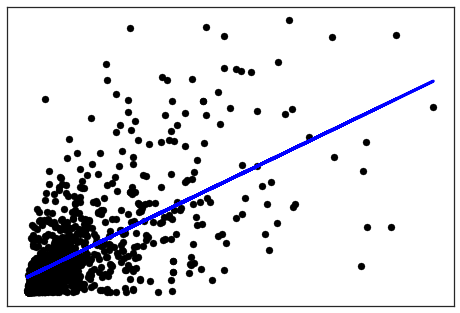

In [5]:
df = movies[['num_voted_users', 'gross']].dropna().reset_index(drop=True)

# Remove outliers
q = df.num_voted_users.quantile(0.99)
df = df[df.num_voted_users < q]
q = df.gross.quantile(0.99)
df = df[df.gross < q]

x = df.num_voted_users.values.reshape(-1, 1)
y = df.gross.values.reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(x, y)
regr = LinearRegression()
regr.fit(x_train, y_train)
print('Variance score: %.2f' % regr.score(x_test, y_test))

plt.scatter(x_test, y_test,  color='black')
plt.plot(x_test, regr.predict(x_test), color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()
plt.clf()

Vytrénovaný model použijeme na doplnenie chýbajúcich hodnôt pre atribút `gross`. Atribút `num_voted_users` obsahujú všetky záznamy, preto sa týmto spôsobom podarilo doplniť všetky chýbajúce hodnoty.

In [6]:
movies.gross = pd.Series([regr.predict(row.num_voted_users)[0][0] if pd.isnull(row.gross) else row.gross for _, row in movies.iterrows()])

### `budget`

Záznamy s chýbajúcim atribútom `budget` predstavujú približne 9.76% datasetu (492 záznamov). Poďla korelačnej matice sa nepodarilo nájsť väčšiu závislosť od iných atribútov, preto sme na doplnenie chýbajúcich hodnôt použili priemer.

In [7]:
movies.budget = movies.budget.fillna(movies.budget.mean())

### `director_facebook_likes`, `actor_1_facebook_likes`, `actor_2_facebook_likes`, `actor_3_facebook_likes`

Chýbajúce hodnoty pre tieto atribúty by bolo možné doplniť podľa iných záznamov s rovnakou hodnotou atribútov `director_name`, `actor_1_name`, `actor_2_name`, `actor_3_name`. V našom datasete ale tieto hodnoty chýbajú v rovnakých záznamoch, preto ich z datasetu odstránime.

In [8]:
movies.dropna(subset=[
    'director_facebook_likes',
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'actor_3_facebook_likes'], inplace=True)
movies.reset_index(drop=True, inplace=True)

### `color`, `title_year`

Atribút `color` obsahuje hodnoty `Color` a ` Black and White`. Tieto hodnoty sme namapovali na hodnoty `0` a `1` podľa toho, či je film farebný alebo čiernobiely.

In [9]:
movies.color.replace(('Color', ' Black and White'), (1, 0), inplace=True)

Po namapovaní hodnôt sa ukázalo, že existuje istá korelácia medzi atribútmi `color` a `title_year` (0.31). Rozhodli sme sa túto závislosť využiť na doplnenie chýbajúcich hodnôt atribútu `color` pomocou rozhodovacieho stromu (decision tree). Záznamy s chýbajúcou hodnotou `title_year` z datasetu odstránime.

In [10]:
movies.dropna(subset=['title_year'], inplace=True)
movies.reset_index(drop=True, inplace=True)

df = movies[['color', 'title_year']].dropna().reset_index(drop=True)

x = df.title_year.values.reshape(-1, 1)
y = df.color.values.reshape(-1, 1)

tree = DecisionTreeClassifier()
tree.fit(x, y)

movies.color = pd.Series([tree.predict(row.title_year)[0] if pd.isnull(row.color) else row.color for _, row in movies.iterrows()]).astype(int)

### `num_critic_for_reviews`, `duration`, `facenumber_in_poster`, `plot_keywords`, `num_user_for_reviews`, `language`, `country`, `aspect_ratio`

Tieto atribúty chýbajú len v malom počte záznamov, preto sme ich z datasetu odstránili.

In [11]:
movies.dropna(subset=[
    'num_critic_for_reviews',
    'duration',
    'facenumber_in_poster',
    'plot_keywords',
    'num_user_for_reviews',
    'language',
    'country',
    'aspect_ratio'], inplace=True)
movies.reset_index(drop=True, inplace=True)

## Vytvorenie nových atribútov

### `profit`

Atribút `profit` sme vytvorili na základe hodnôt `gross` a `budget` pomocou vzorca

$$profit = \frac{gross}{budget} \times 100$$

Hodnota tohto atribútu udáva zisk v percentách zo základného rozpočtu.

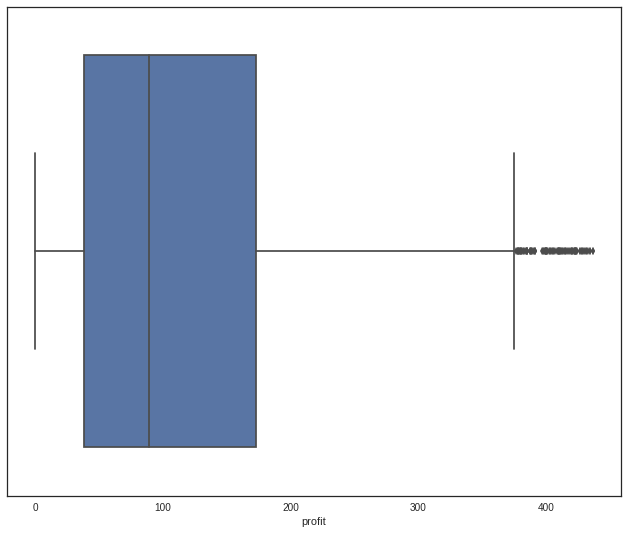

In [12]:
movies['profit'] = pd.Series([((row.gross / row.budget) * 100) for _, row in movies.iterrows()])

# Remove outliers for plotting
df = movies[['profit']].dropna().reset_index(drop=True)
q = df.profit.quantile(0.85)
df = df[df.profit < q]

_, ax = plt.subplots(figsize=(11, 9))
sb.boxplot(x=df.profit, ax=ax)
sb.plt.show()
sb.plt.clf()

### `genres_*`

Atribút `genres` obsahuje zoznam kategórií, do ktorých patrí konkrétny film:

In [13]:
def split_array(array, delimiter='|'):
    if isinstance(array, str):
        return array.split(delimiter)
    return []


def get_array_values(df, column):
    values = set()

    for index, row in df.iterrows():
        for value in split_array(row[column]):
            values.add(value)

    return values


def split_array_column(df, column, delimiter='|'):
    for value in get_array_values(df, column):
        df['{}_{}'.format(column, value)] = pd.Series([int(value in split_array(row[column])) for _, row in df.iterrows()])

    df.drop(column, axis=1, inplace=True)
    return df
    
    
get_array_values(movies, 'genres')


{'Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Romance',
 'Sci-Fi',
 'Sport',
 'Thriller',
 'War',
 'Western'}

Tento zoznam sme použili na vytvorenie nového atribútu pre každú kategóriu, kde hodnoty 0 a 1 udávajú, či daný film patrí do tejto kategórie. V prípade chýbajúcej hodnoty atribútu `genres` nie je film zaradený do žiadnej z kategórií.

In [14]:
split_array_column(movies, 'genres')

,color,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,...,genres_Music,genres_Comedy,genres_Western,genres_Fantasy,genres_Thriller,genres_Adventure,genres_Action,genres_Musical,genres_Sport,genres_Family
0,1,723.0,178.0,0.0,855.0,1000.0,7.605058e+08,886204,4834,0.0,...,0,0,0,1,0,1,1,0,0,0
1,1,302.0,169.0,563.0,1000.0,40000.0,3.094042e+08,471220,48350,0.0,...,0,0,0,1,0,1,1,0,0,0
2,1,602.0,148.0,0.0,161.0,11000.0,2.000742e+08,275868,11700,1.0,...,0,0,0,0,1,1,1,0,0,0
3,1,813.0,164.0,22000.0,23000.0,27000.0,4.481306e+08,1144337,106759,0.0,...,0,0,0,0,1,0,1,0,0,0
4,1,462.0,132.0,475.0,530.0,640.0,7.305868e+07,212204,1873,1.0,...,0,0,0,0,0,1,1,0,0,0
5,1,392.0,156.0,0.0,4000.0,24000.0,3.365303e+08,383056,46055,0.0,...,0,0,0,0,0,1,1,0,0,0
6,1,324.0,100.0,15.0,284.0,799.0,2.008073e+08,294810,2036,1.0,...,0,1,0,1,0,1,0,1,0,1
7,1,635.0,141.0,0.0,19000.0,26000.0,4.589916e+08,462669,92000,4.0,...,0,0,0,0,0,1,1,0,0,0
8,1,375.0,153.0,282.0,10000.0,25000.0,3.019570e+08,321795,58753,3.0,...,0,0,0,1,0,1,0,0,0,1
9,1,673.0,183.0,0.0,2000.0,15000.0,3.302491e+08,371639,24450,0.0,...,0,0,0,0,0,1,1,0,0,0


### `content_rating_*`, `language_*`, `country_*`

Atribúty `content_rating`, `language` a `country` sú rozdelené do binárnych podatribútov podobným spôsobom ako atribút `genres`.

In [15]:
for column in ['content_rating', 'language', 'country']:
    movies[column] = movies[column].astype('category')
    movies = pd.concat([movies, pd.get_dummies(movies[column], prefix=column)], axis=1)
    movies.drop(column, axis=1, inplace=True)

### `topic`

In [16]:
def create_topic_model(df, column, delimiter='|', num_topics=50, passes=10):
    en_stop = get_stop_words('en')
    p_stemmer = PorterStemmer()

    # Cleaning
    texts = []

    for index, row in df.iterrows():
        tokens = list(chain.from_iterable(k.split() for k in split_array(row[column])))
        # Stop words
        tokens = [t for t in tokens if t not in en_stop]
        # Stemming
        tokens = [p_stemmer.stem(t) for t in tokens]

        texts.append(tokens)

    # Create document-term matrix
    dictionary = gensim.corpora.Dictionary(texts)

    # Convert dictionary into bag-of-words
    corpus = [dictionary.doc2bow(text) for text in texts]

    # Apply LDA model
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes)
    print(ldamodel.print_topics(num_topics=num_topics, num_words=3))


## Zhodnotenie

In [19]:
movies.describe()

,color,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,...,country_Soviet Union,country_Spain,country_Sweden,country_Switzerland,country_Taiwan,country_Thailand,country_Turkey,country_UK,country_USA,country_West Germany
count,4528.000000,4528.000000,4528.000000,4528.000000,4528.000000,4528.000000,4.528000e+03,4.528000e+03,4528.000000,4528.000000,...,4528.000000,4528.000000,4528.000000,4528.000000,4528.000000,4528.000000,4528.000000,4528.000000,4528.000000,4528.000000
mean,0.956714,151.929770,109.237191,739.460027,686.871025,6967.914090,4.713770e+07,9.207661e+04,10333.420495,1.356228,...,0.000221,0.006846,0.001104,0.000663,0.000442,0.000883,0.000221,0.091431,0.762147,0.000663
std,0.203523,120.799843,22.545055,2917.258700,1745.835997,14692.251228,6.569579e+07,1.432271e+05,18062.563084,2.007739,...,0.014861,0.082468,0.033215,0.025734,0.021014,0.029712,0.014861,0.288253,0.425816,0.025734
min,0.000000,1.000000,20.000000,0.000000,0.000000,0.000000,1.620000e+02,1.900000e+01,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,63.000000,95.000000,9.000000,151.000000,664.000000,8.528892e+06,1.312125e+04,1580.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1.000000,122.000000,105.000000,56.000000,394.000000,1000.000000,2.404627e+07,4.221950e+04,3393.500000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,208.000000,119.000000,218.000000,651.000000,12000.000000,5.774604e+07,1.072722e+05,14823.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,813.000000,330.000000,23000.000000,23000.000000,640000.000000,7.605058e+08,1.689764e+06,656730.000000,43.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
